In [172]:
# Band structure plotter – extracts data from an nscf output file (calculations='bands') of QE 7.x 

# --- Example: ---
# high_sym_k_points = dict(Γ = [0.0, 0.0, 0.0], X = [0.5, 0.0, 0.0], Y = [0.0, 0.5, 0.0], S = [0.5, 0.5, 0.0])
# bulk = Bandsout("myjob.bands.out", high_sym_k_points)
# bulk.parse()
# bulk.plot(ylim=[-3, 5], Ezero=5.6140, figsize=(4, 6), savefile=True) 
# ---  

import numpy as np
import matplotlib.pyplot as plt
import os
import re
import math

class Bandsout:
  def __init__(self, file_name, symkpts=dict()):
    self.file_name = file_name # nscf output file name
    self.highsym_k = symkpts   # list of high-sym kpoints as "label = [xyz]" (! cart. coord. in units 2pi/alat !)
    self.BOHRtoA = 0.529177249
    self.RYtoeV = 13.605698066
    self.nel    = 0
    self.nup    = 0.0
    self.ndw    = 0.0
    self.nbnd   = 0
    self.nkpt   = 0
    self.kpnts  = []
    self.bndsup = dict()
    self.bndsdw = dict()
    self.symkid = dict()
  def parse(self):
    float_regex  = r".\d+[.]\d+"
    spin_channel = 0
    kcounter     = 0
    with open(self.file_name, "r") as f:
          lines = f.readlines()
    for i in range(len(lines)):
        line = lines[i]
        if "number of electrons" in line:
            found = re.findall(float_regex,line)
            #print(found)
            self.nel = float(found[0])
            self.nup = float(found[1])
            self.ndw = float(found[2])
        if "number of Kohn-Sham states" in line:
            found = re.findall("\d+",line)
            self.nbnd = int(found[0])
            print('Number of bands: ', self.nbnd)
        if "number of k points" in line:
            found = re.findall("\d+",line)
            #print(found)
            self.nkpt = int(found[0])
            print('Number of k-points: ', self.nkpt)
        if "                       cryst. coord." in line:
            # parse through k-point list in the initialiation part of output,
            # find high-symmetry points from the provided list, change xyz coordinates to ids
            for j in range(self.nkpt ):
                found = re.findall(float_regex,lines[i+j+1])
                ik = [ float(found[0]), float(found[1]), float(found[2]) ]
                if ik in self.highsym_k.values():
                    id = list(self.highsym_k.values()).index(ik)
                    self.symkid[j] = list(self.highsym_k.keys())[id]
        
        if re.match("^\s+(k =)",line):
            # collect data for a given k-point
            bands_ik = []
            for j in range(0, math.ceil(self.nbnd/8)):
                found = re.findall(float_regex,lines[i+j+2])
                #print(found)
                for jj in range(8):
                    bands_ik.append(float(found[jj]))
            if spin_channel == 0:
                for ibnd in range(len(bands_ik)):
                    if ibnd not in self.bndsup.keys():
                        self.bndsup[ibnd] = []
                    self.bndsup[ibnd].append(float(bands_ik[ibnd]))
                
                # collect k coordinates but only for spin-up channel 
                found = re.findall(float_regex,line)
                ik = [ float(found[0]), float(found[1]), float(found[2]) ] 
                self.kpnts.append(ik)
            else:
                for ibnd in range(len(bands_ik)):
                    if ibnd not in self.bndsdw.keys():
                        self.bndsdw[ibnd] = []
                    self.bndsdw[ibnd].append(float(bands_ik[ibnd]))

            kcounter += 1
            
        if "------ SPIN DOWN ----------" in line:
            spin_channel = 1
            kcounter     = 0


  def plot(self, ylim=[], Ezero=0.0, figsize=[], savefile=False):
    # x is simply as k-point id
    x = range(0,self.nkpt)
    xlim = [min(x),max(x)]
    if ylim == []:
        ylim = [min(self.bndsup[0]), max(self.bndsup[self.nbnd-1])]

    for i in self.bndsup.keys(): 
        plt.plot(x, np.array(self.bndsdw[i])-Ezero, lw=1.5, color = "#e54030")
        plt.plot(x, np.array(self.bndsup[i])-Ezero, lw=1.5, color = "#3375cc")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.ylabel('Energy (eV)')

    # mark high-sym points if provided
    if len(self.symkid) > 0:
        plt.xticks(list(self.symkid.keys()), list(self.symkid.values()))
        for ix, label in self.symkid.items():
            plt.plot([ix, ix], ylim, color="#929292", ls="solid", alpha = 0.5, lw = 1.0)
    
    if figsize != []:
        plt.rcParams["figure.figsize"] = figsize

    if savefile:
        plt.savefig(self.file_name+'.svg', format = 'svg')
        print('Plot saved as ', self.file_name+'.svg')





Number of bands:  96
Number of k-points:  133
Plot saved as  crsbr_1x1x2_80ry_scan.bands.out.svg


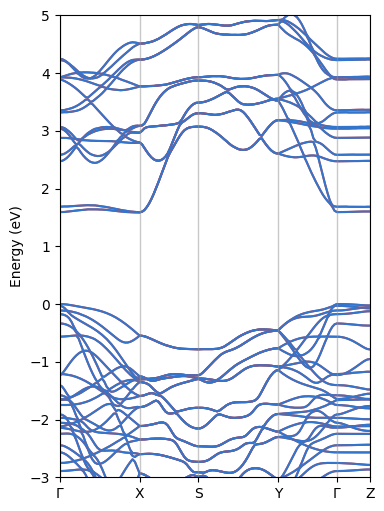

In [257]:
ks = dict(Γ = [0.0, 0.0, 0.0], X = [0.5, 0.0, 0.0], Y = [0.0, 0.5, 0.0], S = [0.5, 0.5, 0.0], Z = [0.0, 0.0, 0.5])

bulk = Bandsout("crsbr_1x1x2_80ry_scan.bands.out", ks)
bulk.parse()
#bulk.plot(ylim=[-6, 7], Ezero=5.6140) 
bulk.plot(ylim=[-3, 5], Ezero=5.6140, figsize=(4, 6), savefile=True) 

